# Chapter 11 - Building the Regression Model III: Remedial Measures

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.graphics.regressionplots as smplot
from statsmodels.stats.api import het_breuschpagan, anova_lm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.formula.api import ols, wls, rlm
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy import stats
import itertools as iter


DATA_DIR = "../data"
yhat = '\u0177'
square = '\u00b2'

# 11.1 Unequal Error Variances Remedial Measures -- Weighted Least Squares (p 421)

### Input Diastolic Blood Pressure (DBP) data

In [2]:
df = pd.read_pickle(f"{DATA_DIR}/CH11TA01.xz")
df.columns = ['X', 'Y']
model = ols("Y ~ X", df).fit()
models = ols("S ~ X", pd.DataFrame({"S": abs(model.resid), "X": df.X})).fit()

In [3]:
models.fittedvalues

0      3.801175
1      2.612141
2      2.810313
3      3.206658
4      3.404830
5      3.008485
6      2.413969
7      2.413969
8      4.197519
9      3.206658
10     3.404830
11     3.999347
12     3.603002
13     5.981070
14     4.792036
15     4.990209
16     4.593864
17     5.188381
18     5.782898
19     5.981070
20     4.990209
21     5.386553
22     4.395692
23     4.593864
24     5.782898
25     6.179242
26     7.566449
27     8.160966
28     6.377415
29     6.773759
30     6.971932
31     7.566449
32     6.971932
33     7.170104
34     7.566449
35     7.764621
36     7.368276
37     8.160966
38     7.962793
39     6.377415
40     6.773759
41     9.349999
42     9.151827
43     9.746344
44     8.755482
45     8.953655
46     9.548172
47     8.755482
48     8.359138
49    10.142689
50     8.359138
51     8.755482
52     9.944516
53     9.746344
dtype: float64

### Table 11.1 (p 427)

Weighted Least Squares -- Blood Pressure Example

In [4]:
pd.DataFrame({
    "Age": df.X,
    "Diastolic BP": df.Y,
    "Error": model.resid,
    "|Error|": abs(model.resid),
    "S": models.fittedvalues,
    "W": 1 / models.fittedvalues**2
}).round(4)

,Age,Diastolic BP,Error,|Error|,S,W
0,27,73,1.1822,1.1822,3.8012,0.0692
1,21,66,-2.3376,2.3376,2.6121,0.1466
2,22,63,-5.9176,5.9176,2.8103,0.1266
3,24,75,4.9223,4.9223,3.2067,0.0973
4,25,71,0.3423,0.3423,3.4048,0.0863
5,23,70,0.5024,0.5024,3.0085,0.1105
6,20,65,-2.7575,2.7575,2.4140,0.1716
7,20,70,2.2425,2.2425,2.4140,0.1716
8,29,79,6.0222,6.0222,4.1975,0.0568
9,24,72,1.9223,1.9223,3.2067,0.0973


Fitted unweighted model results (11.18) on (p 428)

In [5]:
pd.concat([model.params, model.bse], axis=1, keys=["beta", "sd"])

,beta,sd
Intercept,56.156929,3.993674
X,0.580031,0.096951


### Figure 11.1 (p 428)

Diagnostic Plots Detecting Unequal Error Variance -- Blood Pressure Example


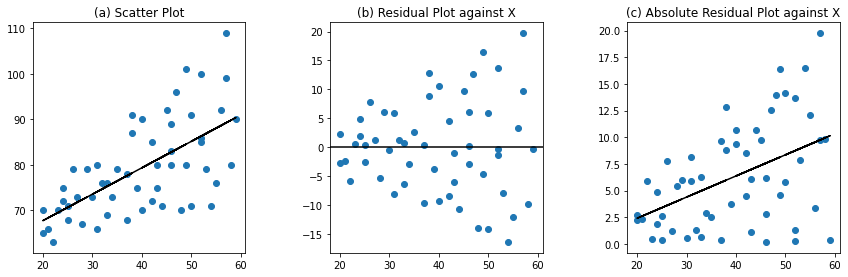

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)

axes[0].scatter(df.X, df.Y)
axes[0].plot(df.X, model.fittedvalues, c='black')

axes[1].scatter(df.X, model.resid)
axes[1].axhline(y=0, c='black')

axes[2].scatter(df.X, abs(model.resid))
axes[2].plot(df.X, models.fittedvalues, c='black')

axes[0].set_title("(a) Scatter Plot")
axes[1].set_title("(b) Residual Plot against X")
axes[2].set_title("(c) Absolute Residual Plot against X")
plt.show()

Using the weights from the absolute residuals fitted values to X, we can make use of the `wls` function imported from the same package as `ols` formula interface. Notice the confidence intevals discussed on (p 429) are automatically computed. 

In [7]:
model = wls("Y ~ X", df, weights=list(1/models.fittedvalues**2)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.521
Model:                            WLS   Adj. R-squared:                  0.512
Method:                 Least Squares   F-statistic:                     56.64
Date:                Mon, 17 May 2021   Prob (F-statistic):           7.19e-10
Time:                        22:09:52   Log-Likelihood:                -181.26
No. Observations:                  54   AIC:                             366.5
Df Residuals:                      52   BIC:                             370.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     55.5658      2.521     22.042      0.000      50.507      60.624
X              0.5963      0.079      7.526      0.000       0.437       0.755
==============================================================================
Omnibus:                        7.974   Durbin-Watson:                   1.853
Prob(Omnibus):                  0.019   Jarque-Bera (JB):                2.701
Skew:                           0.122   Prob(JB):                        0.259
Kurtosis:                       1.932   Cond. No.                         100.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# 11.2 Multicollinearity Remedial Measures -- Ridge Regression (p 431)

### Input Body Fat Data

In [8]:
df = pd.read_pickle(f"{DATA_DIR}/CH07TA01.xz")
df.columns = ['X1', 'X2', 'X3', 'Y']

We create 2 helper functions to perform the calulations. One generates the correlation transformation (7.44), using basic z-score normalization instead.

Next we create a ridge regression computation using the matrix algebra discussed on pages (p 434-436), including the VIF components. This function takes a fitted model object to make the calculations, using the model frame for variable named references.

In [9]:
def normalize(df):
    n = len(df)
    dev = df-df.mean()
    return (1/np.sqrt(n-1)) * (dev / df.std())


def ridge_regression(model, c):
    y = model.model.endog_names
    x = model.model.exog_names[1:]
    p = len(x)
    df = model.model.data.frame
    rxx = df[x].corr()
    rxy = df.corr()[y][:-1]
    bias = np.linalg.inv(rxx + c*np.identity(p))
    return np.concatenate([bias.dot(rxy), np.diag(bias.dot(rxx).dot(bias))])

### Table 11.2 and 11.3 (p 434)

Ridge Estimated Standardized Regression Coefficients for Different Biasing Constants $c$ and VIF Values -- Body Fat Example with Three Predictor Variables.

In [10]:
rc = [0.000, 0.002, 0.004, 0.006, 0.008, 0.010, 0.020, 0.030, 0.040, 0.050, 0.100, 0.500, 1.000]
cols = ["b1", "b2", "b3", "VIF1", "VIF2", "VIF3"]

ndf = normalize(df)
model = ols("Y ~ X1 + X2 + X3", ndf).fit()
trace = pd.DataFrame.from_records([ridge_regression(model, c) for c in rc], index=rc, columns=cols)
trace

,b1,b2,b3,VIF1,VIF2,VIF3
0.000,4.263705,-2.928701,-1.561417,708.842914,564.343386,104.606005
0.002,1.440663,-0.411285,-0.481273,50.559189,40.448310,8.279700
0.004,1.006324,-0.024837,-0.314866,16.981570,13.724723,3.362792
0.006,0.830016,0.131423,-0.247163,8.503322,6.976442,2.118542
0.008,0.734332,0.215763,-0.210302,5.147165,4.304574,1.623800
0.010,0.674173,0.268411,-0.187032,3.485502,2.981273,1.377025
0.020,0.546334,0.377404,-0.136872,1.102551,1.080541,1.010513
0.030,0.500378,0.413414,-0.118078,0.625698,0.696905,0.923458
0.040,0.476004,0.430237,-0.107583,0.452789,0.555289,0.881403
0.050,0.460460,0.439245,-0.100508,0.370454,0.485877,0.853107


### Table 11.2 (again)

This version uses the `statsmodels` approach. This is equivalent, as I understand it, to the *penalized least squares* discussed in comment 4 (p 436)

##### Note

The built-in `variance_inflation_factor` function does not help us here because that uses the fitted model frame. However, each model uses the same frame for each alpha. Unlike the above method, however, it is quite easy to compute the $R^2$ because we have direct access to fitted values, whereas the above method would require building an equation for each bias coefficient.

The `L1_wt` parameter controls how much of the regularization goes to an L1 error (lasso) versus L2 error (ridge). The main difference here is lasso will send coefficients to zero whereas ridge will produce very small nonzero coefficients. Toy around with the parameter and see how it changes the outcomes.

See [docs](https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.OLS.fit_regularized.html) for details. See [Ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) for the scikit-learn approach in an ML context.

In [11]:
reg = {c: ols("Y ~ 0 + X1 + X2 + X3", ndf).fit_regularized(alpha=c, L1_wt=0) for c in rc}
pd.DataFrame.from_records([m.params for m in reg.values()], index=rc, columns=["b1", "b2", "b3"]).round(4)

,b1,b2,b3
0.000,4.2637,-2.9287,-1.5614
0.002,0.4760,0.4302,-0.1076
0.004,0.4341,0.4486,-0.0873
0.006,0.4150,0.4475,-0.0763
0.008,0.4019,0.4418,-0.0681
0.010,0.3914,0.4347,-0.0613
0.020,0.3529,0.3966,-0.0376
0.030,0.3240,0.3629,-0.0229
0.040,0.3001,0.3344,-0.0129
0.050,0.2798,0.3101,-0.0059


In [12]:
pd.DataFrame({
    "Rsq": [1-sum((ndf.Y - m.fittedvalues)**2) for m in reg.values()]
}, index=rc).round(4)

,Rsq
0.000,0.8014
0.002,0.7808
0.004,0.7793
0.006,0.7774
0.008,0.7750
0.010,0.7723
0.020,0.7538
0.030,0.7310
0.040,0.7065
0.050,0.6818


### Figure 11.3 (p 435)

Ridge Trance of Estimated Standardized Regression Coefficients -- Body Fat Example with Three Predictor Variables

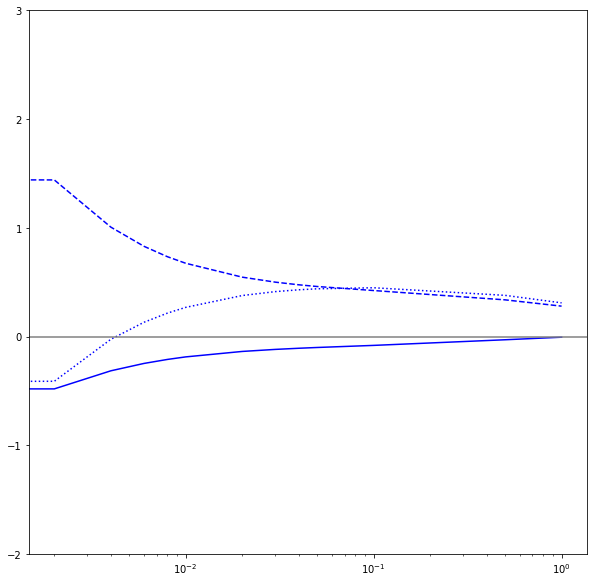

In [13]:
plt.figure(figsize=(10,10))
plt.ylim(-2, 3)
plt.semilogx(trace.index, trace.b1, "b--")
plt.semilogx(trace.index, trace.b2, "b:")
plt.semilogx(trace.index, trace.b3, "b-")
plt.axhline(y=0, c="grey")
plt.show()

# 11.3 Remedial Measures for Influential Cases -- Robust Regression (p 437)

### Input the Mathematics Proficiency Data

In [14]:
df = pd.read_pickle(f"{DATA_DIR}/CH11TA04.xz")
df.columns = ["State", "Y", "X1", "X2", "X3", "X4", "X5"]
dt = pd.concat([df.State, df.X2-df.X2.mean(), df.Y], axis=1)
model1 = ols("Y ~ X2", df).fit()
model2 = ols("Y ~ X2 + I(X2**2)", dt).fit()
modelr = rlm("Y ~ X2 + I(X2**2)", dt, M=sm.robust.norms.HuberT()).fit()
modelr2 = rlm("Y ~ X2 + I(X2**2)", dt, M=sm.robust.norms.TukeyBiweight()).fit()
modell = lowess(df.Y, df.X2)

### Table 11.4 (p 443)

Data Set -- Mathematics Proficiency Example

In [15]:
pd.DataFrame({
    "State": df.State,
    "MATHPROF": df.Y,
    "PARENTS (X1)": df.X1,
    "HOMELIB (X2)": df.X2,
    "READING (X3)": df.X3,
    "TVWATCH (X4)": df.X4,
    "ABSENCES (X5)": df.X5
})

,State,MATHPROF,PARENTS (X1),HOMELIB (X2),READING (X3),TVWATCH (X4),ABSENCES (X5)
0,Alabama,252,75,78,34,18,18
1,Arizona,259,75,73,41,12,26
2,Arkansas,256,77,77,28,20,23
3,California,256,78,68,42,11,28
4,Colorado,267,78,85,38,9,25
5,Connecticut,270,79,86,43,12,22
6,Delaware,261,75,83,32,18,28
7,D.C.,231,47,76,24,33,37
8,Florida,255,75,73,31,19,27
9,Georgia,258,73,80,36,17,22


### Figure 11.5 (p 442)

Comparison of Lowess Ordinary Least Squares Fits and Robust Quadratic Fits -- Mathematical Proficiency Example

##### Note

In plot (e) I also graph the robust linear model using Tukey Bisquare method for comparison and the original standard quadratic line from plot (c).

In plot (f) I also add the Bisquare weights for comparison.

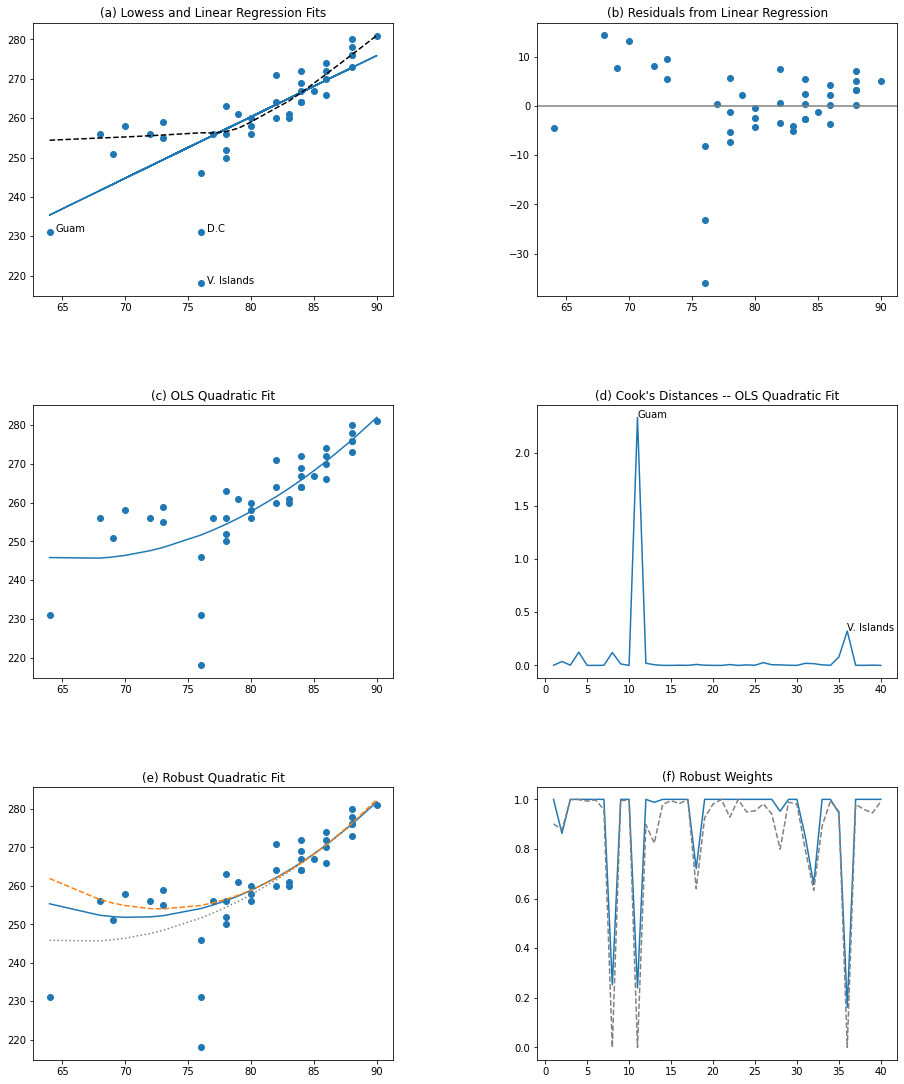

In [16]:
Guam = df.State == 'Guam'
DC = df.State == 'D.C.'
VI = df.State == 'Virgin_Islands'
influence = model2.get_influence().summary_frame()

fig, axes = plt.subplots(3, 2, figsize=(15, 18))
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)

axes[0][0].scatter(df.X2, df.Y)
axes[0][0].plot(df.X2, model1.fittedvalues)
axes[0][0].plot(modell[:, 0], modell[:, 1], "k--")
axes[0][0].text(df.X2[Guam]+0.5, df.Y[Guam], 'Guam')
axes[0][0].text(df.X2[DC]+0.5, df.Y[DC], 'D.C')
axes[0][0].text(df.X2[VI]+0.5, df.Y[VI], 'V. Islands')

axes[0][1].scatter(df.X2, model1.resid)
axes[0][1].axhline(y=0, c="grey")

axes[1][0].scatter(df.X2, df.Y)
axes[1][0].plot(df.X2.sort_values(), model2.predict(dt.sort_values(by="X2")))

axes[1][1].plot(range(1, len(df)+1), influence.cooks_d)
axes[1][1].text(df[Guam].index[0]+1, influence.cooks_d[df[Guam].index[0]], "Guam")
axes[1][1].text(df[VI].index[0]+1, influence.cooks_d[df[VI].index[0]], "V. Islands")

axes[2][0].scatter(df.X2, df.Y)
axes[2][0].plot(df.X2.sort_values(), modelr.predict(dt.sort_values(by="X2")))
axes[2][0].plot(df.X2.sort_values(), model2.predict(dt.sort_values(by="X2")), linestyle="dotted", c='grey')
axes[2][0].plot(df.X2.sort_values(), modelr2.predict(dt.sort_values(by="X2")), linestyle='--')

axes[2][1].plot(range(1, len(df)+1), modelr.weights)
axes[2][1].plot(range(1, len(df)+1), modelr2.weights, c="grey", ls="--")

axes[0][0].set_title("(a) Lowess and Linear Regression Fits")
axes[0][1].set_title("(b) Residuals from Linear Regression")
axes[1][0].set_title("(c) OLS Quadratic Fit")
axes[1][1].set_title("(d) Cook's Distances -- OLS Quadratic Fit")
axes[2][0].set_title("(e) Robust Quadratic Fit")
axes[2][1].set_title("(f) Robust Weights")
plt.show()

For comparison, here are the 2 RLM models using both weighting methods.

In [17]:
display(rlm("Y ~ X2", df, M=sm.robust.norms.HuberT()).fit().summary())
display(rlm("Y ~ X2", df, M=sm.robust.norms.TukeyBiweight()).fit().summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:                      Y   No. Observations:                   40
Model:                            RLM   Df Residuals:                       38
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 17 May 2021                                         
Time:                        22:09:55                                         
No. Iterations:                    14                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    143.0186     12.650     11.306      0.000     118.225     167.812
X2             1.4788      0.157      9.427      0.000       1.171       1.786
==============================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:                      Y   No. Observations:                   40
Model:                            RLM   Df Residuals:                       38
Method:                          IRLS   Df Model:                            1
Norm:                   TukeyBiweight                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 17 May 2021                                         
Time:                        22:09:55                                         
No. Iterations:                    23                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    150.1330     12.343     12.163      0.000     125.941     174.325
X2             1.3973      0.153      9.129      0.000       1.097       1.697
==============================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

### Figure 11.5 (p 444)

Iteratively Huber-Reweighted Least Squares Calculations -- Mathematics Proficiency Example

###### Note

Since the `rlm` function provides the ability to compute these directly and retrieve final weights, I am going to avoid the pedantic work of manually computing them at this time. I'll leave that as an exercise for the interested reader.

For the R approach I took see [rpubs](https://rpubs.com/bryangoodrich/5225)

### Figure 11.6 (p 446)

Scatter Plot Matrix with Lowess Smooths and Correlation Matrix -- Mathematics Proficiency Example

##### Note

Unlike R that has an `spm` function that gives you some easy access to controlling your scatter plot matrix, the pandas version provides you each subplot in a row-wise order. 

By simply iterating through each row and each subplot axis in that row, we can control what extra behavior we want to apply to each cell. 

In this case, if the labels of the subplot axis are the same, we know we're on the diagonal and add the label for the variable via a dictionary lookup. I also chose to display the kernel density estimation to get an idea of its univariate distribution when calling `scatter_matrix`. 

For off-diagonal elements, I pull out the x and y data by the subplot axis labels, fit a lowess model, and add that to the scatter plot. Additionally, I set the title to the correlation between the variables in that cell. 

Improvement might be to remove plotting from the upper or lower triangle and replace it with larger text showing the correlation amount. It would also be more informative to either change the text or background to a cold-hot color gradient according to the correlation. Alternatively, one could plot the absolute correlation and color gradient and let the trend line itself demonstrate whether the correlation is negative or not. 

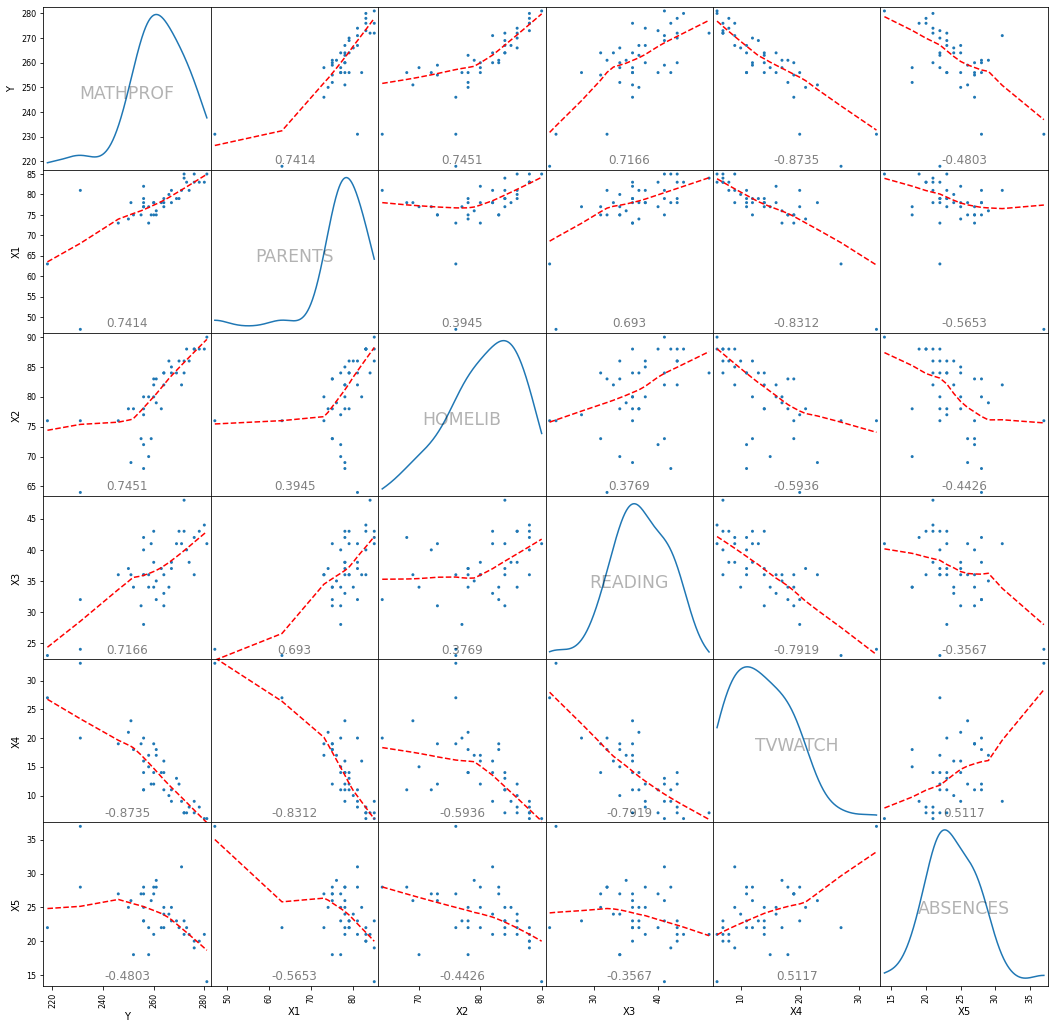

In [18]:
axes = pd.plotting.scatter_matrix(df, alpha=1, diagonal="kde", figsize=(18,18))
lab = {
    "Y": "MATHPROF",
    "X1": "PARENTS",
    "X2": "HOMELIB",
    "X3": "READING",
    "X4": "TVWATCH",
    "X5": "ABSENCES"
}
for row in axes:
    for ax in row:
        if ax.get_xlabel() == ax.get_ylabel():
            ax.set_title(lab[ax.get_xlabel()], y=0.4, alpha=0.3, size="xx-large")
            continue
        x = df[ax.get_xlabel()]
        y = df[ax.get_ylabel()]
        modell = lowess(y, x, frac=0.9)
        ax.plot(modell[:, 0], modell[:, 1], "r--")
        ax.set_title(x.corr(y).round(4), y=0.0, alpha=0.5)
    

### Table 11.6 (p 447)

Diagnostics for First-Order Model with All Five Explanatory Variables -- Mathematics Proficiency Example

In [19]:
influence = ols("Y ~ X1 + X2 + X3 + X4 + X5", df).fit().get_influence().summary_frame()
influence.index = df.State
influence[['hat_diag', 'student_resid', 'cooks_d']].round(2)

,hat_diag,student_resid,cooks_d
State,,,
Alabama,0.16,-0.05,0.00
Arizona,0.19,0.40,0.01
Arkansas,0.16,1.41,0.06
California,0.29,0.10,0.00
Colorado,0.10,-0.57,0.01
Connecticut,0.12,0.03,0.00
Delaware,0.12,0.64,0.01
D.C.,0.69,1.41,0.72
Florida,0.09,1.47,0.03


### Figure 11.7 (p 448)

Best Subsets Regression -- Mathematics Proficiency Example

##### Note

We make use of the approach performed in chapter 9. If we had a Cp calculation (or some other bias metric) we could directly compare, but using the adjusted R squared, AIC, and BIC we see alignment among the criteria and with the text. 

In [20]:
def model_summary(m):
    return (
        m.model.exog_names[1:], 
        len(m.model.exog_names), 
        m.ssr, 
        m.rsquared, 
        m.rsquared_adj, 
        m.aic, 
        m.bic)

pred = ['X1', 'X2', 'X3', 'X4', 'X5']
combos = [[" + ".join(item) for item in iter.combinations(pred, r)] for r in range(1, len(pred)+1)]
formulas = ["Y ~ 1"] + [f"Y ~ 1 + {p}" for parameters in combos for p in parameters]
models = [ols(f, df).fit() for f in formulas]
criteria = [model_summary(model) for model in models]
df_c = pd.DataFrame(criteria, columns = ['Variables', "p", 'SSE', 'Rsq', 'RsqAdj', 'AIC', 'BIC'])
display(df_c.round(2))

,Variables,p,SSE,Rsq,RsqAdj,AIC,BIC
0,[],1,6789.90,0.00,0.00,320.89,322.58
1,[X1],2,3057.53,0.55,0.54,290.97,294.35
2,[X2],2,3020.59,0.56,0.54,290.49,293.87
3,[X3],2,3303.26,0.51,0.50,294.07,297.44
4,[X4],2,1609.43,0.76,0.76,265.31,268.68
5,[X5],2,5223.31,0.23,0.21,312.40,315.77
6,"[X1, X2]",3,1410.53,0.79,0.78,262.03,267.10
7,"[X1, X3]",3,2520.40,0.63,0.61,285.25,290.31
8,"[X1, X4]",3,1604.21,0.76,0.75,267.18,272.24
9,"[X1, X5]",3,3020.14,0.56,0.53,292.48,297.55


In [21]:
model = ols("Y ~ X2 + X3 + X4", df).fit()
modelr = rlm("Y ~ X2 + X3 + X4", df).fit()

display(model.summary())
display(modelr.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     68.76
Date:                Mon, 17 May 2021   Prob (F-statistic):           5.65e-15
Time:                        22:09:59   Log-Likelihood:                -121.31
No. Observations:                  40   AIC:                             250.6
Df Residuals:                      36   BIC:                             257.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    199.6107     21.529      9.272      0.000     155.948     243.273
X2             0.7804      0.170      4.585      0.000       0.435       1.126
X3             0.4012      0.269      1.493      0.144      -0.144       0.946
X4            -1.1565      0.271     -4.261      0.000      -1.707      -0.606
==============================================================================
Omnibus:                       15.142   Durbin-Watson:                   2.844
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               24.035
Skew:                          -0.986   Prob(JB):                     6.04e-06
Kurtosis:                       6.246   Cond. No.                     2.31e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.31e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:                      Y   No. Observations:                   40
Model:                            RLM   Df Residuals:                       36
Method:                          IRLS   Df Model:                            3
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 17 May 2021                                         
Time:                        22:09:59                                         
No. Iterations:                    22                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    207.6858     17.689     11.741      0.000     173.016     242.356
X2             0.7971      0.140      5.700      0.000       0.523       1.071
X3             0.1608      0.221      0.728      0.466      -0.272       0.594
X4            -1.1692      0.223     -5.243      0.000      -1.606      -0.732
==============================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

# 11.4 Nonparametric Regression: Lowess Method and Regression Trees (p 449)

### Input Life Insurance Data

In [24]:
df = pd.read_pickle(f"{DATA_DIR}/CH11TA07.xz")
df.columns = ["X1", "X2", "Y"]

### Table 11.7 (p 451)

Lowess Calculations for Non-Parametric Regression Fit at $X_{h1}=30$, $X_{h2}=3$ -- Life Insurance Example

##### Note

The lowess function from statsmodels does not support multiple regression as it takes a 1-D numpy array for both x and y. But shown here we can see that for a given point the vectorized calculations are pretty straight-forward. Albeit, iterating a large data set like this would be cumbersome. There are no built-in 2D lowess functions in standard libraries. I spent enough time trying to rig my own here and am giving up! This is truly an area where R does a better job, sadly.

In [27]:
X = df[['X1', 'X2']]
p = np.array([30, 3])  # Point of interest
q = 0.5  # Neighborhood proportion
npoints = int(np.ceil(q*X.shape[0]))  # Number of neighbors to collect
dist = np.sqrt((((X - p) / X.std())**2).sum(axis=1))  # Vectorized (11.55)
idx = np.argsort(dist)  # sorted ordered index
dq = dist[idx[npoints-1]]  # the neighborhood boundary, zero indexed
idx = idx[:npoints-1]  # the neighborhood index
weights = pd.DataFrame((1 - (dist[idx]/dq)**3)**3, columns=['weights'])  # tricube weight function (11.56)
dist = pd.DataFrame(dist, columns=['distance'])
w = pd.concat([df, dist, weights], axis=1).replace(np.nan, 0)  # replace NAN in weights to zero when index joined
w

,X1,X2,Y,distance,weights
0,66.290,7,240,3.012536,0.000000
1,40.964,5,73,1.143064,0.299740
2,72.996,10,311,4.211542,0.000000
3,45.010,6,136,1.652847,0.000000
4,57.204,4,183,1.896062,0.000000
5,26.852,5,13,0.893784,0.596683
6,38.122,4,35,0.701410,0.787809
7,35.840,6,61,1.360797,0.086315
8,65.796,9,319,3.560561,0.000000
9,37.408,5,30,1.002924,0.468353


Shown below are the fitted linear model and its prediction for the given point. 

In [28]:
model = wls("Y ~ X1 + X2", w, weights=w.weights).fit()
model.summary()

C:\opt\Anaconda3\lib\site-packages\scipy\stats\stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\opt\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:764: RuntimeWarning: divide by zero encountered in log
  llf += 0.5 * np.sum(np.log(self.weights))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.754
Model:                            WLS   Adj. R-squared:                  0.721
Method:                 Least Squares   F-statistic:                     22.98
Date:                Mon, 17 May 2021   Prob (F-statistic):           2.71e-05
Time:                        22:12:27   Log-Likelihood:                   -inf
No. Observations:                  18   AIC:                               inf
Df Residuals:                      15   BIC:                               inf
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -134.0764     25.553     -5.247      0.000    -188.541     -79.612
X1             3.5715      0.645      5.538      0.000       2.197       4.946
X2            10.5322      4.178      2.521      0.024       1.627      19.437
==============================================================================
Omnibus:                       10.831   Durbin-Watson:                   1.791
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               13.380
Skew:                           0.669   Prob(JB):                      0.00124
Kurtosis:                       7.006   Cond. No.                         263.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [29]:
float(model.predict(pd.DataFrame({"X1": [30], "X2": [3]})))

4.664606985896931

### Figure 11.8 (p 452)

Contour and Conditioning Plots for Lowess Nonparametric Regression -- Life Insurance Example

##### Note

Since python doesn't have a built-in lowess for multiple regression, I'm going to avoid these for now. Instead, similar to what I did in [rpubs](https://rpubs.com/bryangoodrich/5225), I will use the data to make a sequence grid of points on which to fit loess values. I then return this grid data frame (x,y) and the fitted values (z) to make a 3D plot. 

In [31]:
def loess_1(p, formula, data, span=0.5):
    p = np.array(p)
    params = [p.strip() for p in formula.split("~")[1].strip().split("+")]
    X = data[params]
    npoints = int(np.ceil(span*X.shape[0]))
    dist = np.sqrt((((X - p) / X.std())**2).sum(axis=1))
    idx = np.argsort(dist)  # sorted ordered index
    dq = dist[idx[npoints-1]]  # the neighborhood boundary, zero indexed
    idx = idx[:npoints-1]  # the neighborhood index
    weights = pd.DataFrame((1 - (dist[idx]/dq)**3)**3, columns=['weights'])  # tricube weight function (11.56)
    w = pd.concat([data, weights], axis=1).replace(np.nan, 0)  # replace NAN in weights to zero when index joined
    fit = wls(formula, w, weights=w.weights).fit()
    newx = pd.DataFrame(p.reshape(-1, 2), columns=params)
    return float(fit.predict(newx))

def seq(x, n):
    """Returns a sequence of length n evenly spaced points across x"""
    lwr, upr = x.min(), x.max()
    return np.arange(lwr, upr, (upr-lwr)/n)

def loess(formula, data, span=0.5, resolution=30):
    xr = seq(df.X1, resolution)
    yr = seq(df.X2, resolution)
    g = [i.flatten() for i in np.meshgrid(xr, yr)]
    newx = pd.DataFrame({"X1": g[0], "X2": g[1]})
    return {
        "fittedvalues": [loess_1(p, "Y ~ X1 + X2", df) for p in newx.values], 
        "data": newx
    }



In [ ]:
modell = loess("Y ~ X1 + X2", df) # This will take a few seconds!

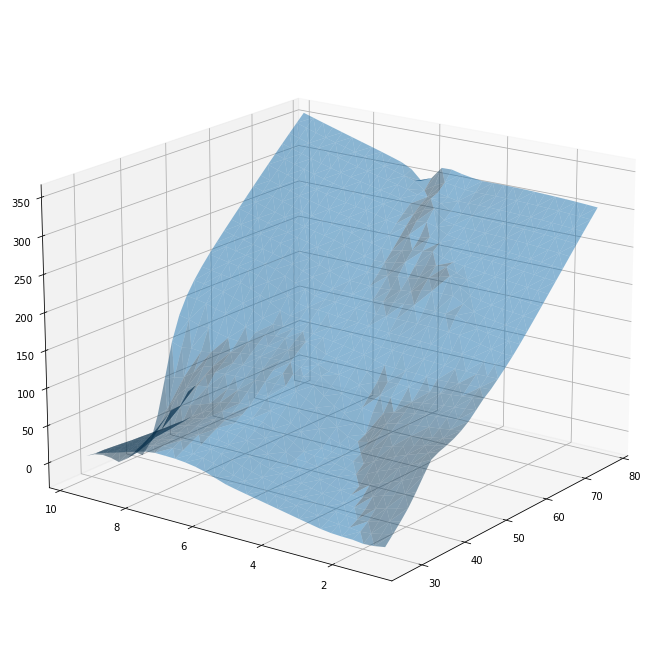

In [32]:
# Interactive
#%matplotlib widget 

# Printed
%matplotlib inline


plt3d = plt.figure(figsize=(12, 12)).gca(projection='3d')
plt3d.plot_trisurf(modell['data'].X1, modell['data'].X2, modell['fittedvalues'], alpha=0.5)
plt3d.view_init(18, -144)  # Set (elevation, azimuth)
plt.show()

### Input Steroid Level Data

In [177]:
df = pd.read_pickle(f"{DATA_DIR}/CH11TA08.xz")
df.columns = ["Y", "X"]
df['Region'] = pd.cut(df.X, bins=[8, 9, 10, 13, 14, 26], labels=range(5), include_lowest=True, right=False)

### Table 11.8 (p 453)

Data Set and 5-Region Regression Tree Fit -- Steroid Level Example

##### Note

Since this is nothing more than defining the cuts in your "tree" as regions, assigned the mean value. I have predefined the regions and displayed everything below. The `dt` dataframe here is just a convenience for mashing together the region averages into the dataframe as fitted values. 

Additionally, the authors specify an open interval on `[14, 25)` but this will not work as we have two points at $X=25$. Therefore, I adjust the region to include the 25.

In [178]:
df.groupby("Region").Y.mean().to_frame()

,Y
Region,
0,3.550000
1,8.133333
2,13.675000
3,16.950000
4,22.268750


The Regions and "Fitted Values"

In [179]:
dt = pd.merge(df, df.groupby("Region").Y.mean().to_frame(), left_on="Region", right_index=True)
dt = dt.sort_values("X")  # For step function to display correctly
dt.columns = ["Y", "X", "Region", "fittedvalue"]
dt

,Y,X,Region,fittedvalue
7,5.7,8.0,0,3.550000
4,1.4,8.0,0,3.550000
16,3.4,9.0,1,8.133333
14,11.8,9.0,1,8.133333
10,9.2,9.0,1,8.133333
12,10.5,10.0,2,13.675000
6,14.7,11.0,2,13.675000
5,18.8,12.0,2,13.675000
3,10.7,12.0,2,13.675000
18,21.1,13.0,3,16.950000


### Figure 11.9 (p 454)

Fitted Regression Tree, Residual Plot, and Regression Tree Diagram -- Steroid Level Example

##### Note

Since this starts by "hardcoding" the definition of a regression tree model, I replicate these outputs. But below I import the `sklearn` library for regression trees and demonstrate some basic machinery for using it (far from a complete demonstration!). Unfortunately, there is no easy syntax similar to R's `rpart` function nor anything I see in or being developed in `statsmodels` for this, unfortunately. A common API for working with trees within `statsmodels` would be convenient. 

See [DecisionTreeRegressor (sklearn)](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html) for more.

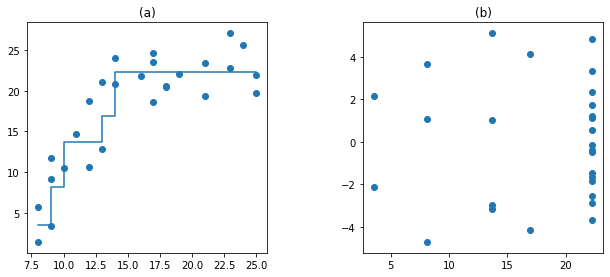

In [180]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)

axes[0].scatter(dt.X, dt.Y)
axes[0].step(dt.X, dt.fittedvalue, where="post")
axes[1].scatter(dt.fittedvalue, dt.Y - dt.fittedvalue)

axes[0].set_title("(a)")
axes[1].set_title("(b)")
plt.show()

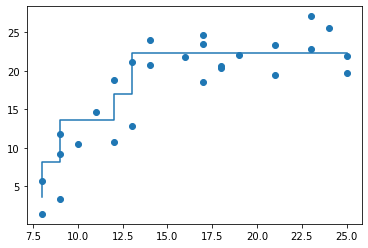

In [181]:
from sklearn import tree
import sklearn.metrics as skmetrics

idx = df.X.sort_values
X = df.X.to_numpy().reshape((27, 1))
y = df.Y.to_numpy().reshape((27,1))
model = tree.DecisionTreeRegressor(max_leaf_nodes=5).fit(X, y)
df['fit'] = model.predict(X)
plt.scatter("X", "Y", data=df.sort_values("X"))
plt.step("X", "fit", data=df.sort_values("X"))


[Text(558.0, 856.1700000000001, 'X[0] <= 12.5\nmse = 47.585\nsamples = 27\nvalue = 17.644'),
 Text(334.8, 611.55, 'X[0] <= 9.5\nmse = 26.506\nsamples = 9\nvalue = 9.578'),
 Text(223.20000000000002, 366.93000000000006, 'X[0] <= 8.5\nmse = 14.288\nsamples = 5\nvalue = 6.3'),
 Text(111.60000000000001, 122.30999999999995, 'mse = 4.623\nsamples = 2\nvalue = 3.55'),
 Text(334.8, 122.30999999999995, 'mse = 12.329\nsamples = 3\nvalue = 8.133'),
 Text(446.40000000000003, 366.93000000000006, 'mse = 11.562\nsamples = 4\nvalue = 13.675'),
 Text(781.2, 611.55, 'X[0] <= 13.5\nmse = 9.322\nsamples = 18\nvalue = 21.678'),
 Text(669.6, 366.93000000000006, 'mse = 17.222\nsamples = 2\nvalue = 16.95'),
 Text(892.8000000000001, 366.93000000000006, 'mse = 5.191\nsamples = 16\nvalue = 22.269')]

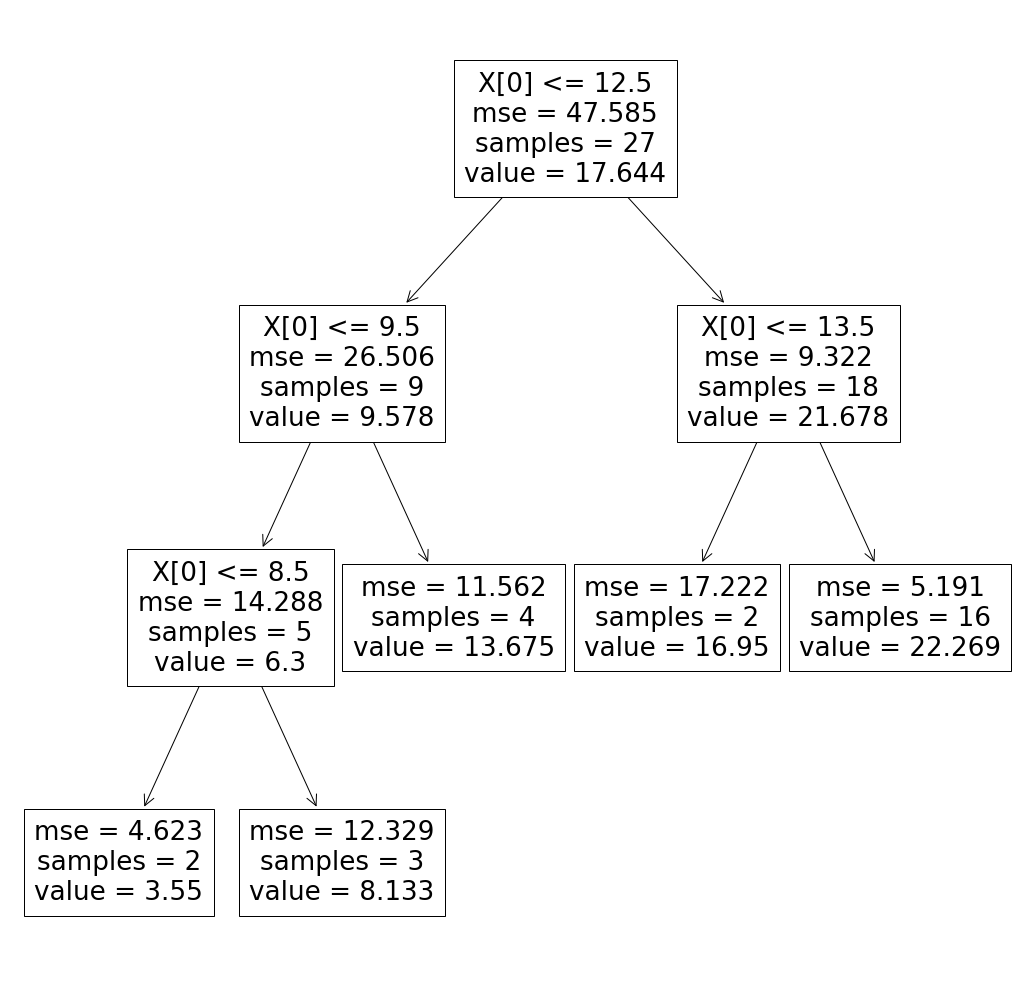

In [182]:
plt.figure(figsize=(18,18))
tree.plot_tree(model)

### Figure 11.10 (p 455)

Growing the Regression Tree -- Steroid Level Example

##### Note

This isn't really how you would "grow" the regression tree. Instead, I'm constraining the max number of leaf nodes to demonstrate what the model optimized with those given constraints. Ideally, you should hold out some test sample on which you tune parameters (not necessarily this `max_leaf_node`) by iterating through some list of possible values and picking the one with the best predictive accuracy. Using something like k-fold valiation, you can maximize the use of your data sample while avoiding overfitting to your training sample.

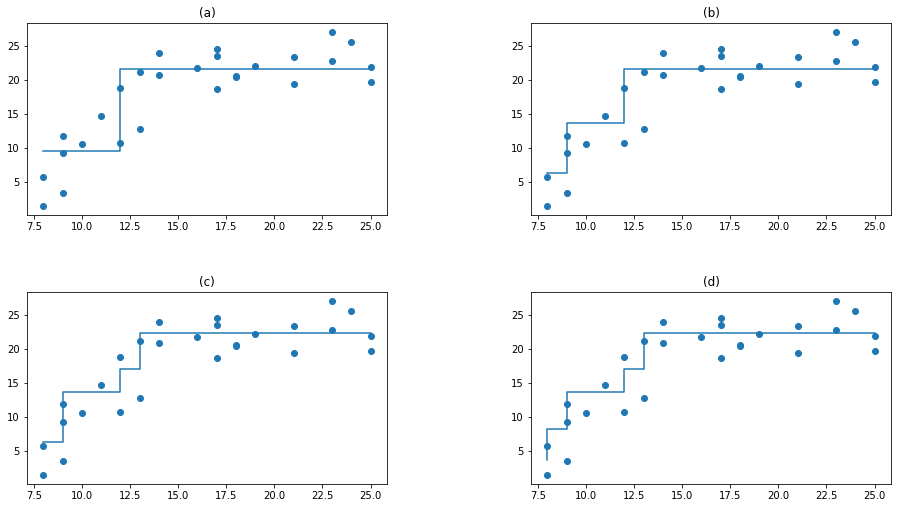

In [183]:
idx = df.X.sort_values
X = df.X.to_numpy().reshape((27, 1))
y = df.Y.to_numpy().reshape((27,1))

fig, axes = plt.subplots(2, 2, figsize=(15, 8))
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
t = ['(a)', '(b)', '(c)', '(d)']

for i, ax in enumerate(axes.flatten()):
    model = tree.DecisionTreeRegressor(max_leaf_nodes=i+2).fit(X, y)
    df['fit'] = model.predict(X)
    ax.scatter("X", "Y", data=df.sort_values("X"))
    ax.step("X", "fit", data=df.sort_values("X"))
    ax.set_title(t[i])


**Note**: At this time I will skip the multiple tree regression example on page 457. A more in-depth review of performing tree models with sklearn would be more beneficial, and no need to show off "fancy" 3D step functions that only work in that bivariabe regressor case. 

# 11.5 Remedial Measures for Evaluating Precision in Nonstandard Situations -- Bootstrapping (p 458)

### Input the Toluca Company Data

In [116]:
df = pd.read_pickle(f"{DATA_DIR}/CH11TA09.xz")
df.columns = ["X", "Y"]

### Table 11.9 (p 461)

Bootstrapping with Fixed X Sampling -- Toluca Company Example

In [117]:
model = ols("Y ~ X", df).fit()
pd.DataFrame({
    "X": df.X,
    "Y": df.Y,
    yhat: model.fittedvalues,
    "e": model.resid
})

,X,Y,ŷ,e
0,80,399,347.982020,51.017980
1,30,121,169.471919,-48.471919
2,50,221,240.875960,-19.875960
3,90,376,383.684040,-7.684040
4,70,361,312.280000,48.720000
5,60,224,276.577980,-52.577980
6,120,546,490.790101,55.209899
7,80,352,347.982020,4.017980
8,100,353,419.386061,-66.386061
9,50,157,240.875960,-83.875960


Here we make use of the built-in sample feature of pandas dataframes, generating 1000 bootstrap samples as a python generator. This produces a *promise* to get 1000 samples, not that it manifests it in memory. Of course, then we fit 1000 models (which also hold the dataframe in memory), so it's only a slight memory improvement. In any case, this does take a second to run!

In [118]:
bootstrap = (df.sample(frac=1, replace=True) for _ in range(5000))
models = [ols("Y ~ X", _).fit() for _ in bootstrap]

In [119]:
pd.DataFrame({
    "X": df.X,
    "Y": df.Y,
    yhat: models[0].fittedvalues.to_list(),
    "e": models[0].resid.to_list()
})

,X,Y,ŷ,e
0,80,399,378.457627,-1.457627
1,30,121,183.196970,-23.196970
2,50,221,300.353364,60.646636
3,90,376,378.457627,-1.457627
4,70,361,339.405496,12.594504
5,60,224,222.249101,-1.249101
6,120,546,144.144838,-23.144838
7,80,352,183.196970,60.803030
8,100,353,300.353364,22.646636
9,50,157,300.353364,-48.353364


### Figure 11.13 (p 461)

Histogram of Bootstrap Estimates $b^{*}_1$ -- Toluca Company Example

In [122]:
alpha = 0.05
b = [m.params[1] for m in models]
bstar = np.percentile(b, alpha/2*100), np.percentile(b, 100-alpha/2*100), np.std(b)
display(bstar)

d = model.params[1] - bstar[0], bstar[1] - model.params[1]
d = model.params[1] - d[1], model.params[1] + d[0], model.params[1]
display(d)

(2.8477874272119377, 4.283879826976797, 0.36848368994928504)

(2.8565242134272424, 4.292616613192102, 3.5702020202020197)

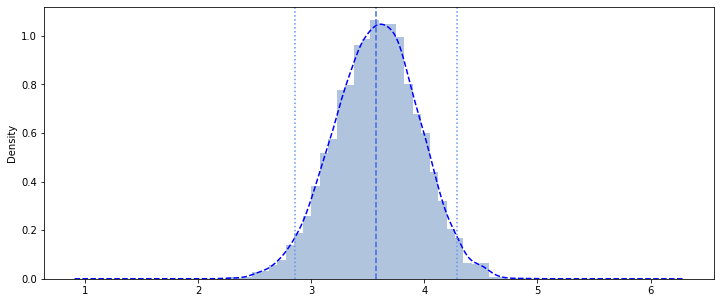

In [204]:
fig, ax = plt.subplots(1, figsize=(12,5))
                       
ax.hist(b, bins="scott", density=True, color='lightsteelblue')
pd.DataFrame({"b*": b}).plot.kde(color='blue', linestyle='dashed', figsize=(12,5), ax=ax, legend=False)
ax.axvline(x=d[0], c='cornflowerblue', linestyle='dotted')
ax.axvline(x=d[1], c='cornflowerblue', linestyle='dotted')
ax.axvline(x=d[2], c='royalblue', linestyle='dashed')
plt.show()

### Input Blood Pressure Data

In [13]:
df = pd.read_pickle(f"{DATA_DIR}/CH11TA10.xz")
df.columns = ["X", "Y"]

Here is a helper function to perform the weighted least squares with estimated weights, returning the components relevant to our presentation results.

In [14]:
def auto_wls(X, y, constant=True):
    x = sm.add_constant(X) if constant else X
    model = sm.OLS(y,x).fit()
    s = sm.OLS(abs(model.resid), x).fit()
    return {
        "wls": sm.WLS(y, x, weights=1 / (s.fittedvalues**2)).fit(),
        "ols": model,
        "std": s
    }

In [15]:
bootstrap = [df.sample(frac=1, replace=True) for _ in range(5000)]
models = [auto_wls(b.X, b.Y) for b in bootstrap]
model = auto_wls(df.X, df.Y)

### Table 11.10 (p 462)

Bootstrapping with Random X Sampling -- Blood Pressure Example

In [5]:
pd.DataFrame({
    "X": df.X,
    "Y": df.Y,
    "X*": models[0]['ols'].model.exog[:, 1],
    "Y*": models[0]['ols'].fittedvalues.to_list(),
    "e*": models[0]['ols'].resid.to_list(),
    "s*": models[0]['std'].fittedvalues.to_list(),
    "w*": (1 / models[0]['std'].fittedvalues**2).to_list()
})

,X,Y,X*,Y*,e*,s*,w*
0,27,73,27.0,71.575217,1.424783,3.972670,0.063363
1,21,66,39.0,80.227019,-5.227019,6.517522,0.023542
2,22,63,25.0,70.133250,0.866750,3.548528,0.079415
3,24,75,57.0,93.204721,5.795279,10.334799,0.009363
4,25,71,33.0,75.901118,-6.901118,5.245096,0.036349
5,23,70,28.0,72.296201,-5.296201,4.184741,0.057104
6,20,65,24.0,69.412267,5.587733,3.336457,0.089832
7,20,70,38.0,79.506035,7.493965,6.305451,0.025152
8,29,79,49.0,87.436853,-7.436853,8.638231,0.013401
9,24,72,24.0,69.412267,2.587733,3.336457,0.089832


##### Note

I do not know if it's a problem with my resampling or the book, but the $d_1$ computed here is off, causing the upper bound of the confidence interval to be off from the text. 

In [16]:
alpha = 0.05
b = [m['wls'].params[1] for m in models]
bstar = np.percentile(b, alpha/2*100), np.percentile(b, 100-alpha/2*100), np.std(b)
display(bstar)

d = model['wls'].params[1] - bstar[0], bstar[1] - model['wls'].params[1]
d = model['wls'].params[1] - d[1], model['wls'].params[1] + d[0], model['wls'].params[1]
display(d)

(0.4285946152875216, 0.7584837047601991, 0.08572912709205922)

(0.4341997243098896, 0.7640888137825672, 0.5963417145350444)

### Figure 11.14

Histogram of Bootstrap Estimates $b^{*}_1$ -- Blood Pressure Example

##### Note

Included here is a kernel density plot that provides a "smooth histogram," more clearly depicting the distribution of bootstrap estimated $b^{*}_1$. Additionally, the estimate and the $b^{*}_1(0.025)$ and $b^{*}_1(0.975)$ cutoffs are drawn. 

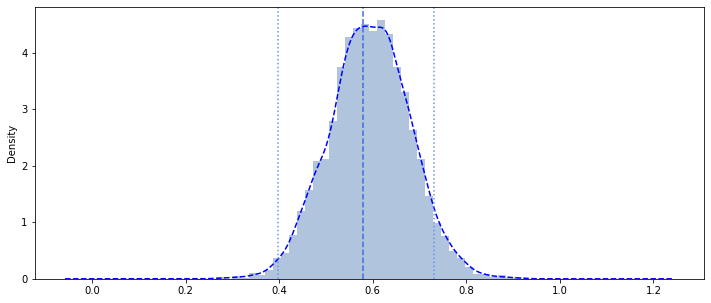

In [7]:
fig, ax = plt.subplots(1, figsize=(12,5))
                       
ax.hist(b, bins="scott", density=True, color='lightsteelblue')
pd.DataFrame({"b*": b}).plot.kde(color='blue', linestyle='dashed', figsize=(12,5), ax=ax, legend=False)
ax.axvline(x=d[0], c='cornflowerblue', linestyle='dotted')
ax.axvline(x=d[1], c='cornflowerblue', linestyle='dotted')
ax.axvline(x=d[2], c='royalblue', linestyle='dashed')
plt.show()

# 11.6 Case Example -- MNDOT Traffic Estimation (p 464)

### Input Traffic Data

In [146]:
df = pd.read_pickle(f"{DATA_DIR}/CH11TA11.xz")
labels = {
    "Y": "AADT",
    "X1": "CTYPOP",
    "X2": "LANES", 
    "X3": "WIDTH",
    "X4": "CONTROL",
    "X5": "CLASS",
    "X6": "TRUCK",
    "X7": "LOCALE"
}
df.columns = labels.keys()
dt = df.apply(lambda x: (x-x.mean())/x.std() if x.name in ['X1', 'X2'] else x) # You'll need this later

### Table 11.11 (p 465)

Data -- MNDOT Traffic Estimation Example

##### Note

For the interested reader, I show how you can use `get_dummies` to convert a list of factors into separate binary variables. This isn't necessary, so this is purely pedagogical. 

In [24]:
pd.get_dummies(df, columns=["X5", "X6", "X7"])

,Y,X1,X2,X3,X4,X5_1,X5_2,X5_3,X5_4,X6_1,X6_2,X6_3,X6_4,X6_5,X7_1,X7_2,X7_3
0,1616,13404,2,52,2,0,1,0,0,0,0,0,0,1,1,0,0
1,1329,52314,2,60,2,0,1,0,0,0,0,0,0,1,1,0,0
2,3933,30982,2,57,2,0,0,0,1,0,0,0,0,1,0,1,0
3,3786,25207,2,64,2,0,0,0,1,0,0,0,0,1,0,1,0
4,465,20594,2,40,2,0,1,0,0,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,13723,941411,2,44,2,0,0,0,1,0,0,0,0,1,0,1,0
117,21535,941411,4,60,2,0,0,0,1,0,0,0,0,1,0,0,1
118,14905,459784,4,68,2,0,0,0,1,0,0,0,0,1,0,1,0
119,15408,459784,2,40,2,0,0,0,1,0,0,0,0,1,0,0,1


### Figure 11.15 (p 466)

Scatter Plot Matrix -- MNDOT Traffic Estimation Example

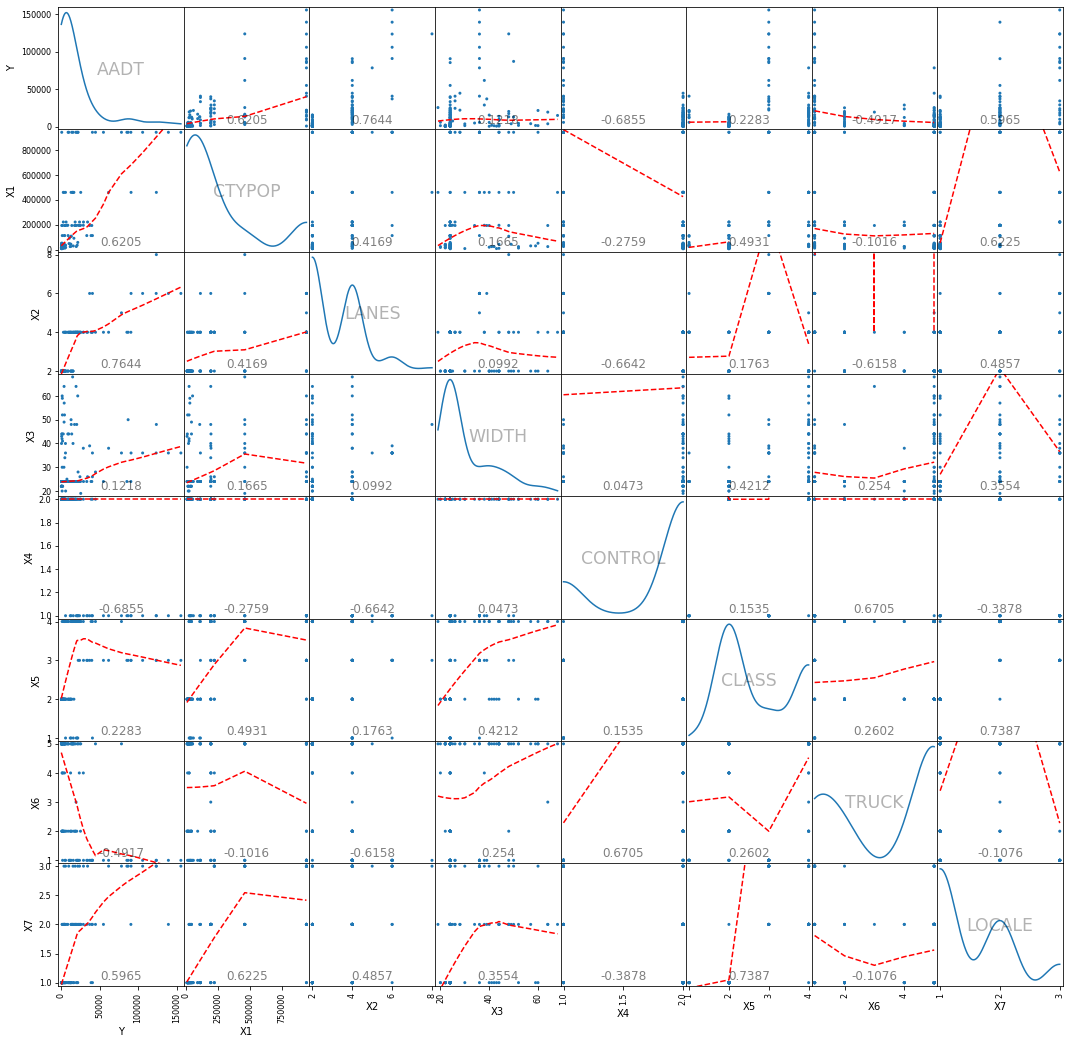

In [32]:
axes = pd.plotting.scatter_matrix(df, alpha=1, diagonal="kde", figsize=(18,18))

for ax in axes.flatten():
    if ax.get_xlabel() == ax.get_ylabel():
        ax.set_title(labels[ax.get_xlabel()], y=0.4, alpha=0.3, size="xx-large")
        continue
    x = df[ax.get_xlabel()]
    y = df[ax.get_ylabel()]
    modell = lowess(y, x, frac=0.90)
    ax.plot(modell[:, 0], modell[:, 1], "r--")
    ax.set_title(x.corr(y).round(4), y=0.0, alpha=0.5)

As noted in the text, a first-order model with all regressors is fit. Note the contrast coding for the indicator variables is specified with the `C(...)` expression.

In [71]:
model = ols("Y ~ X1 + X2 + X3 + C(X4) + C(X5) + C(X6) + C(X7)", df).fit()
display(model.summary())
influence = model.get_influence()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.823
Model:                            OLS   Adj. R-squared:                  0.802
Method:                 Least Squares   F-statistic:                     38.29
Date:                Tue, 18 May 2021   Prob (F-statistic):           3.06e-34
Time:                        22:25:20   Log-Likelihood:                -1314.7
No. Observations:                 121   AIC:                             2657.
Df Residuals:                     107   BIC:                             2697.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -2.731e+04   8449.105     -3.232      0.002   -4.41e+04   -1.06e+04
C(X4)[T.2] -2.771e+04   1.46e+04     -1.902      0.060   -5.66e+04    1174.884
C(X5)[T.2]   2.87e+04   1.63e+04      1.759      0.081   -3650.076    6.11e+04
C(X5)[T.3]  4.648e+04    1.2e+04      3.874      0.000    2.27e+04    7.03e+04
C(X5)[T.4]  3.536e+04   1.83e+04      1.933      0.056    -909.605    7.16e+04
C(X6)[T.2]  -444.5363   6563.266     -0.068      0.946   -1.35e+04    1.26e+04
C(X6)[T.3]   415.6364   1.55e+04      0.027      0.979   -3.04e+04    3.12e+04
C(X6)[T.4]  7409.3402   7867.982      0.942      0.348   -8188.016     2.3e+04
C(X6)[T.5]  2215.3488   6656.190      0.333      0.740    -1.1e+04    1.54e+04
C(X7)[T.2] -1.365e+04   1.02e+04     -1.336      0.184   -3.39e+04    6602.290
C(X7)[T.3] -1.093e+04   1.11e+04     -0.981      0.329    -3.3e+04    1.11e+04
X1             0.0277      0.005      5.585      0.000       0.018       0.038
X2          9660.9873   1568.500      6.159      0.000    6551.620    1.28e+04
X3           128.1552    129.376      0.991      0.324    -128.317     384.627
==============================================================================
Omnibus:                       23.750   Durbin-Watson:                   1.253
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              112.903
Skew:                           0.427   Prob(JB):                     3.04e-25
Kurtosis:                       7.654   Cond. No.                     9.51e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.51e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Also discussed (p 465), the residual plot against predictions suggests nonconstant error variance. Variance inflation can be computed, as well (max VIF 24.55). But as mentioned, cook's distance of only about 0.20 is not suggesting great influence by any individual cases. 

C:\opt\Anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:693: RuntimeWarning: invalid value encountered in sqrt
  return self.resid / sigma / np.sqrt(1 - hii)


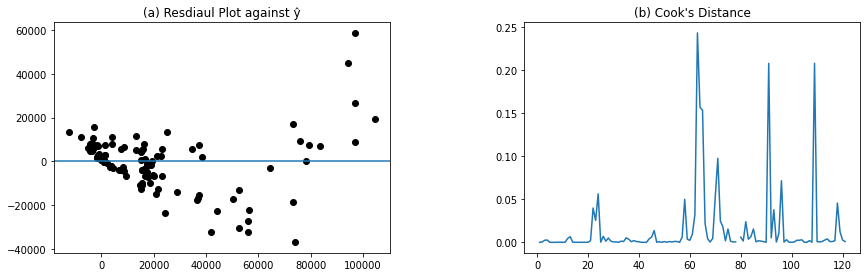

In [72]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)

axes[0].scatter(model.fittedvalues, model.resid, c='black')
axes[0].axhline(y=0)

axes[1].plot(range(1, len(df)+1), influence.cooks_distance[0])

axes[0].set_title(f"(a) Resdiaul Plot against {yhat}")
axes[1].set_title("(b) Cook's Distance")
plt.show()

### Figure 11.16 (p 467)

All Possible Regressions Output -- MNDOT Traffic Estimation Example

##### Note

It is important to note that when the text refers to $X_7 (CLASS=3)$ they mean the indicator variable of just class=3. This is not going to be captured here because we're using direct contrast coding, not passing each variable in separately as dummy variables.

As mentioned in text (p 465-466), this best subsets search required CTYPOP ($X_1$) and LANES ($X_2$) to be included. We accomplished this when building the models in a list comprehension by adding the conditional clause that the variable terms had to be in the formula `f`. 

Also, using the contrast coding makes identifying the individual models a bit harder. This is one downside of using the model information instead of the source permutation list. This can be improved upon in the future. 

In [73]:
def model_summary(m):
    return (
        m.model.exog_names[1:], 
        len(m.model.exog_names), 
        m.ssr, 
        m.rsquared, 
        m.rsquared_adj, 
        m.aic, 
        m.bic)

pred = ['X1', 'X2', 'X3', 'C(X4)', 'C(X5)', 'C(X6)', 'C(X7)']
combos = [[" + ".join(item) for item in iter.combinations(pred, r)] for r in range(1, len(pred)+1)]
formulas = ["Y ~ 1"] + [f"Y ~ 1 + {p}" for parameters in combos for p in parameters]
models = [ols(f, df).fit() for f in formulas if "X1" in f and "X2" in f]
criteria = [model_summary(model) for model in models]
df_c = pd.DataFrame(criteria, columns = ['Variables', "p", 'SSE', 'Rsq', 'RsqAdj', 'AIC', 'BIC'])
display(df_c.sort_values("p").round(2))

,Variables,p,SSE,Rsq,RsqAdj,AIC,BIC
0,"[X1, X2]",3,3.350845e+10,0.69,0.69,2701.54,2709.92
1,"[X1, X2, X3]",4,3.350844e+10,0.69,0.69,2703.54,2714.72
2,"[C(X4)[T.2], X1, X2]",4,2.728054e+10,0.75,0.74,2678.65,2689.84
5,"[C(X7)[T.2], C(X7)[T.3], X1, X2]",5,3.066272e+10,0.72,0.71,2694.80,2708.78
6,"[C(X4)[T.2], X1, X2, X3]",5,2.712823e+10,0.75,0.74,2679.98,2693.96
3,"[C(X5)[T.2], C(X5)[T.3], C(X5)[T.4], X1, X2]",6,2.115749e+10,0.81,0.80,2651.90,2668.67
12,"[C(X4)[T.2], C(X7)[T.2], C(X7)[T.3], X1, X2]",6,2.617965e+10,0.76,0.75,2677.67,2694.45
9,"[C(X7)[T.2], C(X7)[T.3], X1, X2, X3]",6,3.065040e+10,0.72,0.71,2696.75,2713.52
10,"[C(X4)[T.2], C(X5)[T.2], C(X5)[T.3], C(X5)[T.4...",7,2.032059e+10,0.81,0.81,2649.02,2668.59
18,"[C(X4)[T.2], C(X7)[T.2], C(X7)[T.3], X1, X2, X3]",7,2.611860e+10,0.76,0.75,2679.39,2698.96


The selected model. Note that we're not removing an entire dummy encoding to collapse CLASS=2 and CLASS=4 into one group. Maybe the best subsets approach without contrast coding and using actual dummy variables might suggest this. I leave that as an exercise to the interested reader.

As discussed, the centered squared values can be added to the pool of predictors, but this will also not be shown for brevity's sake!

In [147]:
model = ols("Y ~ X1 + X2 + C(X4) + C(X5)", df).fit()
model2 = ols("Y ~ X1*C(X4) + X2 + I(X2**2)", dt).fit()
display(model.summary())
display(model2.summary())

influence = model.get_influence().summary_frame()
influence2 = model2.get_influence().summary_frame()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.815
Model:                            OLS   Adj. R-squared:                  0.805
Method:                 Least Squares   F-statistic:                     83.59
Date:                Tue, 18 May 2021   Prob (F-statistic):           2.07e-39
Time:                        23:08:19   Log-Likelihood:                -1317.5
No. Observations:                 121   AIC:                             2649.
Df Residuals:                     114   BIC:                             2669.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -2.326e+04   7473.944     -3.113      0.002   -3.81e+04   -8457.834
C(X4)[T.2] -3.019e+04   1.39e+04     -2.167      0.032   -5.78e+04   -2589.256
C(X5)[T.2]  3.258e+04   1.47e+04      2.218      0.029    3480.045    6.17e+04
C(X5)[T.3]  3.569e+04   6190.331      5.766      0.000    2.34e+04     4.8e+04
C(X5)[T.4]   2.86e+04   1.48e+04      1.937      0.055    -656.611    5.79e+04
X1             0.0272      0.005      5.682      0.000       0.018       0.037
X2          9484.6985   1372.018      6.913      0.000    6766.742    1.22e+04
==============================================================================
Omnibus:                       24.407   Durbin-Watson:                   1.273
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              113.620
Skew:                           0.465   Prob(JB):                     2.13e-25
Kurtosis:                       7.655   Cond. No.                     8.54e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.54e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.925
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                     281.9
Date:                Tue, 18 May 2021   Prob (F-statistic):           8.69e-63
Time:                        23:08:19   Log-Likelihood:                -1263.2
No. Observations:                 121   AIC:                             2538.
Df Residuals:                     115   BIC:                             2555.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      2.471e+04   2228.486     11.089      0.000    2.03e+04    2.91e+04
C(X4)[T.2]    -1.522e+04   2536.256     -6.001      0.000   -2.02e+04   -1.02e+04
X1             2.662e+04   1472.331     18.080      0.000    2.37e+04    2.95e+04
X1:C(X4)[T.2] -2.282e+04   1784.758    -12.786      0.000   -2.64e+04   -1.93e+04
X2             8744.6857   1230.891      7.104      0.000    6306.527    1.12e+04
I(X2 ** 2)     3970.7604    620.345      6.401      0.000    2741.977    5199.544
==============================================================================
Omnibus:                       23.223   Durbin-Watson:                   1.789
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              119.772
Skew:                           0.357   Prob(JB):                     9.82e-27
Kurtosis:                       7.821   Cond. No.                         9.11
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Figure 11.17 (p 468)

Plots of Studentized Residuals versus Fitted Values -- MNDOT Traffic Estimation Example

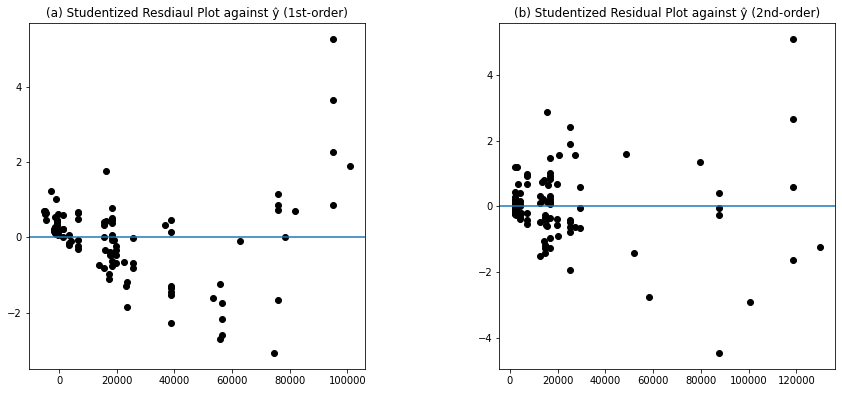

In [148]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)

axes[0].scatter(model.fittedvalues, influence.student_resid, c='black')
axes[0].axhline(y=0)

axes[1].scatter(model2.fittedvalues, influence2.student_resid, c='black')
axes[1].axhline(y=0)

axes[0].set_title(f"(a) Studentized Resdiaul Plot against {yhat} (1st-order)")
axes[1].set_title(f"(b) Studentized Residual Plot against {yhat} (2nd-order)")
plt.show()

Discussed (p 468), the VIF max is 2.5. However, as we can see below our use of the function suggests otherwise. It is still low. Additionally, cook's distance with a max of 0.47 suggests no influential cases. 

A Breusch-Pagan test can be conducted to further validate nonconstant error is still an issue.

In [149]:
display([variance_inflation_factor(model2.model.data.exog, i) for i in range(1, model2.model.data.exog.shape[1])])
display(influence2.cooks_d.describe().round(4))

[1.8748710098971593,
 3.6146898984573888,
 3.3478466864181398,
 2.526385128301341,
 1.6300052140986645]

count    121.0000
mean       0.0211
std        0.0754
min        0.0000
25%        0.0001
50%        0.0006
75%        0.0058
max        0.4727
Name: cooks_d, dtype: float64

### Figure 11.18 (p 469)

Weighted Least Squares Regression Results -- MNDOT Traffic Estimation Example

In [162]:
wls_model = ols("Y ~ X1*C(X4) + X2 + I(X2**2)", dt).fit()
for _ in range(3):
    fit = ols("E ~ X1 + X2", pd.DataFrame({"E": abs(wls_model.resid), "X1": dt.X1, "X2": dt.X2})).fit()
    w = fit.fittedvalues**(-2)
    wls_model = wls("Y ~ X1*C(X4) + X2 + I(X2**2)", dt, weights=w).fit()

display(anova_lm(wls_model, typ=2))
display(wls_model.summary())

,sum_sq,df,F,PR(>F)
C(X4),37.214770,1.0,18.845367,3.065374e-05
X1,126.966019,1.0,64.294936,9.928875e-13
X1:C(X4),112.982678,1.0,57.213845,1.044654e-11
X2,85.974019,1.0,43.536799,1.332344e-09
I(X2 ** 2),17.494893,1.0,8.859324,3.555667e-03
Residual,227.095522,115.0,NaN,NaN


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.802
Model:                            WLS   Adj. R-squared:                  0.793
Method:                 Least Squares   F-statistic:                     93.13
Date:                Tue, 18 May 2021   Prob (F-statistic):           8.99e-39
Time:                        23:16:30   Log-Likelihood:                -1207.2
No. Observations:                 121   AIC:                             2426.
Df Residuals:                     115   BIC:                             2443.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      2.616e+04   2736.866      9.558      0.000    2.07e+04    3.16e+04
C(X4)[T.2]    -1.656e+04   2966.007     -5.582      0.000   -2.24e+04   -1.07e+04
X1             2.579e+04   2590.792      9.953      0.000    2.07e+04    3.09e+04
X1:C(X4)[T.2] -2.099e+04   2774.445     -7.564      0.000   -2.65e+04   -1.55e+04
X2             8010.5329   1214.040      6.598      0.000    5605.752    1.04e+04
I(X2 ** 2)     3802.2023   1277.424      2.976      0.004    1271.872    6332.533
==============================================================================
Omnibus:                       58.951   Durbin-Watson:                   1.739
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              220.043
Skew:                           1.735   Prob(JB):                     1.65e-48
Kurtosis:                       8.622   Cond. No.                         29.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Figure 11.19 (p 470)

Residual Plots for Fitted Weighted Least Squares Regression Fit -- MNDOT Traffic Estimation Example

##### Note

Since the WLSResult object does not contain a `get_influence` method, I'm not sure how to get studentized residuals in an automated way. One trick that supposedly works (looks about right) is to simply pull out the design matrix (endog and exog) and fit an OLS object with them. 

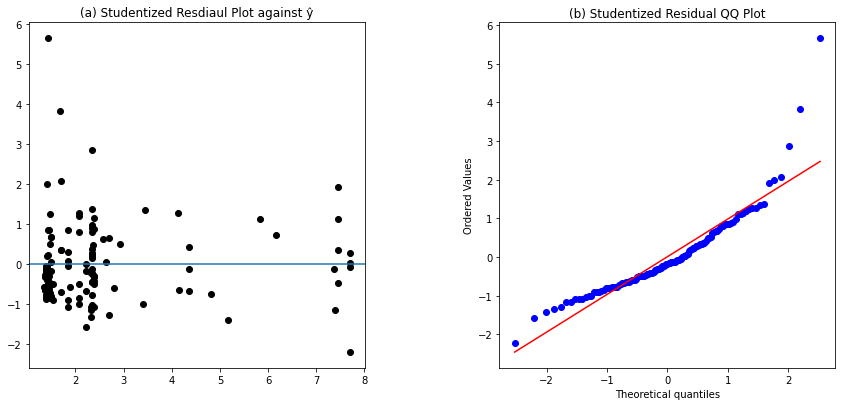

In [163]:
model = sm.OLS(wls_model.model.wendog, wls_model.model.wexog).fit()
influence = model.get_influence().summary_frame()

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)

axes[0].scatter(model.fittedvalues, influence.student_resid, c='black')
axes[0].axhline(y=0)

stats.probplot(influence.student_resid, plot=axes[1])

axes[0].set_title(f"(a) Studentized Resdiaul Plot against {yhat}")
axes[1].set_title("(b) Studentized Residual QQ Plot")
plt.show()

### Table 11.12 (p 470)

95 Percent Approximate Confidence Limits for Mean responses -- MNDOT Traffic Estimation Example

I leave this as a worthy exercise since the model design doesn't match the simple dataframe we want to insert into our prediction! Will require more research

In [169]:
newx = pd.DataFrame({
    "X1": [113571, 222229, 941411],
    "X2": [2, 4, 6],
    "X4": [0, 0, 1]
})
display(newx)
#model.get_prediction(newx).summary_frame()

,X1,X2,X4
0,113571,2,0
1,222229,4,0
2,941411,6,1
